In [ ]:
# Download The Data From Kaggle Website
# Source File --->>>    https://www.kaggle.com/c/m5-forecasting-accuracy/data

#!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.190 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,hi;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/18599/1236839/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1615089586&Signature=nPzCjKZfcAwVFRPUdhvtM0D7oHfObUYgTC18tqAwql2bk%2B9l6DpA1UNOvcIhmJs7gfoIndRdZN%2FQWdn36x8YvMa0z9dImMGN5znprFhVM8wVzlCWRVhYQ0h2nR1qxe57rxuBggjVrKsUUpasX8XoQULkSU%2Bc5jcm35zNCQcDxUkWOiz77FDXYOkQ7YRwlISY7fSXaNnfOZgiPhmhXYjGo4s7tJEyZ5pjk6xYnfZ63lUNCOMKQfg%2FVc9HBvCOQLsEApog6gisf2N8Wya7rhn5Uc%2F9YcndmyeEaIHSpWzs9bD48XU1rU5dfTx2myR9dDhiz5HAzeGMKqUaeHclZXrVRw%3D%3D&response-content-disposition=attachment%3B+filename%3Dm5-forecasting-accuracy.zip" -c -O 'm5-forecasting-accuracy.zip'

In [ ]:
#!unzip m5-forecasting-accuracy.zip

In [ ]:
# import all the Libaries

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
import random
import joblib

In [ ]:
# Read All the Csv Files

sales = pd.read_csv("sales_train_evaluation.csv")
price = pd.read_csv("sell_prices.csv")
cal = pd.read_csv("calendar.csv")

In [ ]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


**WRMMSE CODE**

In [ ]:
price["id"] = price["item_id"] + "_" + price["store_id"] + "_evaluation"
cal["d"] = cal["d"].apply(lambda a: int(a.split("_")[1]))

In [ ]:
#https://www.kaggle.com/qcw171717/other-naive-forecasts-submission-score/notebook

for day in tqdm(range(1886, 1914)):  
    wk_id = list(cal[cal["d"]==day]["wm_yr_wk"])[0]
    wk_price = price[price["wm_yr_wk"]==wk_id]
    df_sales = sales.merge(wk_price[["sell_price", "id"]], on=["id"], how='inner')
    df_sales["unit_sales_" + str(day)] = df_sales["sell_price"] * df_sales["d_" + str(day)]
    df_sales.drop(columns=["sell_price"], inplace=True)

100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


In [ ]:
col = [a for a in df_sales.columns if a.find("unit_sales")==0]
df_sales["sales"] = df_sales[col]
df_sales["weight"] = df_sales["sales"] / df_sales["sales"].sum()
df_sales.drop(columns=["sales", col[0]], axis=1, inplace=True)
df_sales["weight"] /= 12

In [ ]:
aggregation_level = {2: ["state_id"], 3: ["store_id"], 4: ["cat_id"], 5: ["dept_id"], 
              6: ["state_id", "cat_id"], 7: ["state_id", "dept_id"], 8: ["store_id", "cat_id"], 9: ["store_id", "dept_id"],
              10: ["item_id"], 11: ["item_id", "state_id"]}

In [ ]:
#function to calculate rmsse 

h = 28
n = 1913

def RMSSE(ground_truth, forecast, train_series):
    
    num = ((ground_truth - forecast)**2).sum(axis=1)
    den = 1/(n-1) * ((train_series[:, 1:] - train_series[:, :-1]) ** 2).sum(axis=1)
    rmsse = (1/h * num/den) ** 0.5

    return rmsse

In [ ]:
# function to compute custom hyperparametrer tuning

def hyperparameter_tuning(pred_df,df_sales):

    df_sales = df_sales.join(pred_df)

    data = df_sales[[a for a in df_sales.columns if a.find("d_") == 0 or a.find("F_") == 0]]
    data = data.sum()

    aggregated_df = pd.DataFrame(data).transpose()    
    aggregated_df["level"] = 1
    aggregated_df["weight"] = 1/12    
    columns = aggregated_df.columns  

    for lev in aggregation_level:
        df_t = df_sales.groupby(by=aggregation_level[lev]).sum().reset_index()
        df_t["level"] = lev
        aggregated_df = aggregated_df.append(df_t[columns])     

    train_columns = [a for a in df_sales.columns if a.find("d_") == 0 and int(a.split('_')[1]) < 1914]
    actual_value_columns = [a for a in df_sales.columns if a.find("d_") == 0 and int(a.split('_')[1]) in range(1914, 1942)]
    forecast_value_columns = [a for a in df_sales.columns if a.find("F_") == 0]    

    ground_truth_df = np.array(df_sales[actual_value_columns])
    forecast_df = np.array(df_sales[forecast_value_columns])
    train_series_df = np.array(df_sales[train_columns])

    ground_truth_agg_df = np.array(aggregated_df[actual_value_columns])
    forecast_agg_df = np.array(aggregated_df[forecast_value_columns])
    train_series_agg_df = np.array(aggregated_df[train_columns])

    df_sales["rmsse"] = RMSSE(ground_truth_df, forecast_df, train_series_df)
    aggregated_df["rmsse"] = RMSSE(ground_truth_agg_df, forecast_agg_df, train_series_agg_df)

    df_sales["wrmsse"] = df_sales["weight"] * df_sales["rmsse"]
    aggregated_df["wrmsse"] = aggregated_df["weight"] * aggregated_df["rmsse"]

    print(df_sales["wrmsse"].sum() + aggregated_df["wrmsse"].sum())
    
    return (df_sales["wrmsse"].sum() + aggregated_df["wrmsse"].sum())

### A. Extra Tree Regressor

In [ ]:
# https://machinelearningmastery.com/multi-output-regression-models-with-python/
# Multioutput regression are regression problems that involve predicting two or more numerical values given an input example.

In [ ]:
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,weight
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1,0.000004
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0,0.000000
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1,0.000002
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6,0.000005
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0,0.000006


In [ ]:
# Dummy EncodingConvert 
# categorical variable into dummy/indicator variables

df = df_sales[["id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "weight"]].join(pd.get_dummies(df_sales.drop(columns=["id", "item_id", "weight"])))

In [ ]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,weight,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,...,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.000004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0.000002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0.000005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0.000006,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
x = df.columns

In [ ]:
train_part1 = df[x[7:1948]]
train_part1.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [ ]:
train_part2 = df[x[1948:]]
train_part2

,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI
0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
30486,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
30487,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
30488,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


**Training Dataset**

In [ ]:
k1 = train_part1.columns[1050:(1941-56)]
train = train_part1[k1]
X = pd.concat([train, train_part2], axis=1, sort=False)
X

,d_1051,d_1052,d_1053,d_1054,d_1055,d_1056,d_1057,d_1058,d_1059,d_1060,d_1061,d_1062,d_1063,d_1064,d_1065,d_1066,d_1067,d_1068,d_1069,d_1070,d_1071,d_1072,d_1073,d_1074,d_1075,d_1076,d_1077,d_1078,d_1079,d_1080,d_1081,d_1082,d_1083,d_1084,d_1085,d_1086,d_1087,d_1088,d_1089,d_1090,...,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI
0,0,3,0,1,1,2,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,2,0,0,1,0,2,0,0,0,0,0,0,1,0,...,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,2,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,1,4,3,0,0,1,2,2,6,2,0,0,3,0,10,5,1,3,2,4,4,2,0,1,4,1,0,2,5,1,1,0,1,1,2,2,2,0,0,0,...,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,3,0,0,1,4,1,0,2,2,5,0,0,1,2,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,3,1,0,0,0,0,2,0,1,1,2,...,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,1,0,2,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,2,2,0,0,0,0,0,0,3,0,0,1,0,2,2,2,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
30486,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
30487,0,5,0,1,2,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,2,2,2,1,1,3,1,3,2,1,1,0,1,1,1,0,1,...,3,1,1,0,3,1,1,2,0,0,2,0,0,0,2,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
30488,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,3,3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,1,3,0,3,1,1,1,1,1,1,0,2,1,1,2,4,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


**Training  Data Target Variable**

In [ ]:
k2 = train_part1.columns[(1941-56):(1941-28)]
Y = train_part1[k2]
Y.head()

,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


**Cross Validation DataSet**

In [ ]:
k_v = train_part1.columns[(1050+28):(1941-28)]
p1 = train_part1[k_v]
cross_X = pd.concat([p1, train_part2], axis=1, sort=False)
cross_X.head()

,d_1079,d_1080,d_1081,d_1082,d_1083,d_1084,d_1085,d_1086,d_1087,d_1088,d_1089,d_1090,d_1091,d_1092,d_1093,d_1094,d_1095,d_1096,d_1097,d_1098,d_1099,d_1100,d_1101,d_1102,d_1103,d_1104,d_1105,d_1106,d_1107,d_1108,d_1109,d_1110,d_1111,d_1112,d_1113,d_1114,d_1115,d_1116,d_1117,d_1118,...,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI
0,0,1,0,2,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,2,0,0,0,0,0,0,1,2,0,0,0,...,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,1,0,1,1,1,0,0,0,...,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,5,1,1,0,1,1,2,2,2,0,0,0,3,2,8,5,2,2,1,1,2,4,2,0,0,5,0,2,4,6,2,0,1,3,0,5,3,0,3,1,...,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,3,1,0,0,0,0,2,0,1,1,2,0,0,4,2,2,1,2,0,1,3,1,0,0,0,0,2,0,0,2,0,2,1,0,1,1,1,0,2,...,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0


**Cross Validation Target Variable**

In [ ]:
k2 = train_part1.columns[(1941-28):(1941)]
Corss_Y = train_part1[k2]
Corss_Y.head()

,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


**Testing DataSet**

In [ ]:
k_v = train_part1.columns[(1050+28+28):(1941)]
p2 = train_part1[k_v]
test_X = pd.concat([p1, train_part2], axis=1, sort=False)
test_X.head()

,d_1079,d_1080,d_1081,d_1082,d_1083,d_1084,d_1085,d_1086,d_1087,d_1088,d_1089,d_1090,d_1091,d_1092,d_1093,d_1094,d_1095,d_1096,d_1097,d_1098,d_1099,d_1100,d_1101,d_1102,d_1103,d_1104,d_1105,d_1106,d_1107,d_1108,d_1109,d_1110,d_1111,d_1112,d_1113,d_1114,d_1115,d_1116,d_1117,d_1118,...,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI
0,0,1,0,2,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,2,0,0,0,0,0,0,1,2,0,0,0,...,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,1,0,1,1,1,0,0,0,...,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,5,1,1,0,1,1,2,2,2,0,0,0,3,2,8,5,2,2,1,1,2,4,2,0,0,5,0,2,4,6,2,0,1,3,0,5,3,0,3,1,...,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,3,1,0,0,0,0,2,0,1,1,2,0,0,4,2,2,1,2,0,1,3,1,0,0,0,0,2,0,0,2,0,2,1,0,1,1,1,0,2,...,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
%%time

wrmsse=[]
number_of_trees = []
depth_of_trees=[]


for kk in tqdm(range(10)):
    df_sales1 = df_sales.copy()

    number_of_tree = random.randint(20, 50)
    depth_of_tree = random.randint(10, 30)

    print("number_of_tree ",number_of_tree)
    print("depth_of_tree ",depth_of_tree)
   
    
    model = ExtraTreesRegressor(n_estimators=number_of_tree, max_depth=depth_of_tree,n_jobs=-1)

    model.fit(X, Y)

    pred_test = model.predict(cross_X)
    pred_df = pd.DataFrame(pred_test)
    pred_df.columns = ['F_' + str(c) for c in np.arange(1,29,1)]

    WRMSSE = hyperparameter_tuning(pred_df,df_sales1)

    model_name = 'ExtraTreesRegressor'+'_Model_' +str(kk) +'.pkl'
    # save model
    joblib.dump(model, model_name)

    wrmsse.append(WRMSSE)
    number_of_trees.append(number_of_tree)
    depth_of_trees.append(depth_of_tree) 


  0%|          | 0/10 [00:00<?, ?it/s]

number_of_tree  28
depth_of_tree  21


 10%|█         | 1/10 [02:38<23:45, 158.34s/it]

0.8291917320508592
number_of_tree  28
depth_of_tree  20


 20%|██        | 2/10 [05:22<21:19, 159.94s/it]

0.8368781492862937
number_of_tree  31
depth_of_tree  25


 30%|███       | 3/10 [09:00<20:41, 177.41s/it]

0.8221566031627263
number_of_tree  29
depth_of_tree  14


 40%|████      | 4/10 [10:38<15:22, 153.82s/it]

0.8759117838935865
number_of_tree  20
depth_of_tree  14


 50%|█████     | 5/10 [11:51<10:47, 129.43s/it]

0.8703294282631024
number_of_tree  20
depth_of_tree  23


 60%|██████    | 6/10 [13:59<08:35, 128.92s/it]

0.8248586066986433
number_of_tree  42
depth_of_tree  25
0.8174795582332355


 70%|███████   | 7/10 [18:41<08:44, 174.87s/it]

number_of_tree  26
depth_of_tree  22


 80%|████████  | 8/10 [21:13<05:36, 168.06s/it]

0.8271303533832344
number_of_tree  22
depth_of_tree  30
0.8128545315877072


 90%|█████████ | 9/10 [24:14<02:51, 171.93s/it]

number_of_tree  24
depth_of_tree  14


100%|██████████| 10/10 [25:44<00:00, 154.46s/it]

0.8799186708572267
CPU times: user 47min 27s, sys: 9.82 s, total: 47min 37s
Wall time: 25min 44s


In [ ]:
wrmsse

[0.8291917320508592,
 0.8368781492862937,
 0.8221566031627263,
 0.8759117838935865,
 0.8703294282631024,
 0.8248586066986433,
 0.8174795582332355,
 0.8271303533832344,
 0.8128545315877072,
 0.8799186708572267]

In [ ]:
# load model
best_Model  =  joblib.load('ExtraTreesRegressor_Model_8.pkl')

In [ ]:
xx  = best_Model.predict(test_X)

In [ ]:
pred_df = pd.DataFrame(xx)
pred_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.536936,0.694216,0.722582,0.882385,0.794745,1.111089,1.063431,0.849625,0.866186,0.747332,0.542132,1.161681,1.084807,1.114798,0.749714,0.914589,0.767372,0.829130,0.753684,1.088140,1.173171,0.627709,0.913992,0.629793,0.851175,0.614911,1.013465,0.992770
1,0.164498,0.147680,0.154070,0.162656,0.207921,0.240038,0.251539,0.181692,0.172951,0.170700,0.180534,0.213024,0.248788,0.279534,0.183264,0.186368,0.175497,0.178845,0.199509,0.243020,0.259249,0.181987,0.196599,0.192731,0.193866,0.220352,0.261490,0.257850
2,0.526055,0.504003,0.450772,0.542372,0.571931,0.745015,0.919841,0.645879,0.588721,0.630956,0.547430,0.606314,0.965050,1.081031,0.583837,0.549643,0.462428,0.594480,0.678494,0.853031,0.941319,0.732488,0.713756,0.493924,0.481106,0.703112,0.747449,0.738697
3,1.888290,2.059322,1.132512,2.595532,2.178737,2.882897,2.274268,3.325116,2.465331,1.651772,1.963790,3.212635,2.939908,3.895223,2.639445,1.332820,1.600154,2.306626,2.285054,2.174114,3.119414,2.142527,1.920647,1.845146,1.775039,1.699538,3.430663,3.296610
4,1.445470,0.916767,0.925985,1.247695,1.871963,1.783630,1.406542,1.506928,1.191574,0.795003,1.059361,1.352306,1.594780,1.674957,1.515478,1.026320,0.630909,0.710170,1.329602,1.411938,1.154526,0.783201,0.713173,1.243119,1.237890,1.108235,2.044328,1.491056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0.351090,0.359108,0.362181,0.391836,0.499899,0.600713,0.642850,0.432377,0.412724,0.427486,0.370260,0.409692,0.629223,0.685004,0.579390,0.430509,0.489234,0.403934,0.460833,0.450674,0.602862,0.474049,0.414396,0.365308,0.345903,0.525985,0.626572,0.592817
30486,0.330306,0.287079,0.278849,0.307696,0.365585,0.458998,0.480969,0.364763,0.342904,0.341204,0.326997,0.364116,0.483074,0.521133,0.392119,0.371037,0.340239,0.336658,0.383387,0.408477,0.482451,0.367938,0.365905,0.333073,0.323481,0.357744,0.446653,0.447415
30487,0.720728,0.462027,0.541278,0.800509,0.619588,0.944225,0.774447,0.628958,0.676055,0.729883,0.579144,0.919419,0.865152,1.004828,0.721416,0.662439,0.659896,0.747815,0.824191,0.974985,0.798048,0.671971,0.385943,0.522220,0.541504,0.927749,0.670141,0.845372
30488,0.635591,0.618596,0.913325,0.710379,1.166649,1.556421,1.203323,1.270566,0.628343,0.767647,1.126827,1.130574,1.380125,1.557774,1.091594,0.981596,0.988578,0.873452,0.673470,1.426550,1.245928,0.853451,0.702241,0.654796,0.863296,1.315117,1.152192,1.359807


In [ ]:
pred_df.columns = ['F' + str(c) for c in np.arange(1,29,1)]

In [ ]:
pred_df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,0.536936,0.694216,0.722582,0.882385,0.794745,1.111089,1.063431,0.849625,0.866186,0.747332,0.542132,1.161681,1.084807,1.114798,0.749714,0.914589,0.767372,0.829130,0.753684,1.088140,1.173171,0.627709,0.913992,0.629793,0.851175,0.614911,1.013465,0.992770
1,0.164498,0.147680,0.154070,0.162656,0.207921,0.240038,0.251539,0.181692,0.172951,0.170700,0.180534,0.213024,0.248788,0.279534,0.183264,0.186368,0.175497,0.178845,0.199509,0.243020,0.259249,0.181987,0.196599,0.192731,0.193866,0.220352,0.261490,0.257850
2,0.526055,0.504003,0.450772,0.542372,0.571931,0.745015,0.919841,0.645879,0.588721,0.630956,0.547430,0.606314,0.965050,1.081031,0.583837,0.549643,0.462428,0.594480,0.678494,0.853031,0.941319,0.732488,0.713756,0.493924,0.481106,0.703112,0.747449,0.738697
3,1.888290,2.059322,1.132512,2.595532,2.178737,2.882897,2.274268,3.325116,2.465331,1.651772,1.963790,3.212635,2.939908,3.895223,2.639445,1.332820,1.600154,2.306626,2.285054,2.174114,3.119414,2.142527,1.920647,1.845146,1.775039,1.699538,3.430663,3.296610
4,1.445470,0.916767,0.925985,1.247695,1.871963,1.783630,1.406542,1.506928,1.191574,0.795003,1.059361,1.352306,1.594780,1.674957,1.515478,1.026320,0.630909,0.710170,1.329602,1.411938,1.154526,0.783201,0.713173,1.243119,1.237890,1.108235,2.044328,1.491056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0.351090,0.359108,0.362181,0.391836,0.499899,0.600713,0.642850,0.432377,0.412724,0.427486,0.370260,0.409692,0.629223,0.685004,0.579390,0.430509,0.489234,0.403934,0.460833,0.450674,0.602862,0.474049,0.414396,0.365308,0.345903,0.525985,0.626572,0.592817
30486,0.330306,0.287079,0.278849,0.307696,0.365585,0.458998,0.480969,0.364763,0.342904,0.341204,0.326997,0.364116,0.483074,0.521133,0.392119,0.371037,0.340239,0.336658,0.383387,0.408477,0.482451,0.367938,0.365905,0.333073,0.323481,0.357744,0.446653,0.447415
30487,0.720728,0.462027,0.541278,0.800509,0.619588,0.944225,0.774447,0.628958,0.676055,0.729883,0.579144,0.919419,0.865152,1.004828,0.721416,0.662439,0.659896,0.747815,0.824191,0.974985,0.798048,0.671971,0.385943,0.522220,0.541504,0.927749,0.670141,0.845372
30488,0.635591,0.618596,0.913325,0.710379,1.166649,1.556421,1.203323,1.270566,0.628343,0.767647,1.126827,1.130574,1.380125,1.557774,1.091594,0.981596,0.988578,0.873452,0.673470,1.426550,1.245928,0.853451,0.702241,0.654796,0.863296,1.315117,1.152192,1.359807


In [ ]:
sub3 = pd.concat([sales['id'], pred_df], axis=1, sort=False)
sub3

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0.536936,0.694216,0.722582,0.882385,0.794745,1.111089,1.063431,0.849625,0.866186,0.747332,0.542132,1.161681,1.084807,1.114798,0.749714,0.914589,0.767372,0.829130,0.753684,1.088140,1.173171,0.627709,0.913992,0.629793,0.851175,0.614911,1.013465,0.992770
1,HOBBIES_1_002_CA_1_evaluation,0.164498,0.147680,0.154070,0.162656,0.207921,0.240038,0.251539,0.181692,0.172951,0.170700,0.180534,0.213024,0.248788,0.279534,0.183264,0.186368,0.175497,0.178845,0.199509,0.243020,0.259249,0.181987,0.196599,0.192731,0.193866,0.220352,0.261490,0.257850
2,HOBBIES_1_003_CA_1_evaluation,0.526055,0.504003,0.450772,0.542372,0.571931,0.745015,0.919841,0.645879,0.588721,0.630956,0.547430,0.606314,0.965050,1.081031,0.583837,0.549643,0.462428,0.594480,0.678494,0.853031,0.941319,0.732488,0.713756,0.493924,0.481106,0.703112,0.747449,0.738697
3,HOBBIES_1_004_CA_1_evaluation,1.888290,2.059322,1.132512,2.595532,2.178737,2.882897,2.274268,3.325116,2.465331,1.651772,1.963790,3.212635,2.939908,3.895223,2.639445,1.332820,1.600154,2.306626,2.285054,2.174114,3.119414,2.142527,1.920647,1.845146,1.775039,1.699538,3.430663,3.296610
4,HOBBIES_1_005_CA_1_evaluation,1.445470,0.916767,0.925985,1.247695,1.871963,1.783630,1.406542,1.506928,1.191574,0.795003,1.059361,1.352306,1.594780,1.674957,1.515478,1.026320,0.630909,0.710170,1.329602,1.411938,1.154526,0.783201,0.713173,1.243119,1.237890,1.108235,2.044328,1.491056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0.351090,0.359108,0.362181,0.391836,0.499899,0.600713,0.642850,0.432377,0.412724,0.427486,0.370260,0.409692,0.629223,0.685004,0.579390,0.430509,0.489234,0.403934,0.460833,0.450674,0.602862,0.474049,0.414396,0.365308,0.345903,0.525985,0.626572,0.592817
30486,FOODS_3_824_WI_3_evaluation,0.330306,0.287079,0.278849,0.307696,0.365585,0.458998,0.480969,0.364763,0.342904,0.341204,0.326997,0.364116,0.483074,0.521133,0.392119,0.371037,0.340239,0.336658,0.383387,0.408477,0.482451,0.367938,0.365905,0.333073,0.323481,0.357744,0.446653,0.447415
30487,FOODS_3_825_WI_3_evaluation,0.720728,0.462027,0.541278,0.800509,0.619588,0.944225,0.774447,0.628958,0.676055,0.729883,0.579144,0.919419,0.865152,1.004828,0.721416,0.662439,0.659896,0.747815,0.824191,0.974985,0.798048,0.671971,0.385943,0.522220,0.541504,0.927749,0.670141,0.845372
30488,FOODS_3_826_WI_3_evaluation,0.635591,0.618596,0.913325,0.710379,1.166649,1.556421,1.203323,1.270566,0.628343,0.767647,1.126827,1.130574,1.380125,1.557774,1.091594,0.981596,0.988578,0.873452,0.673470,1.426550,1.245928,0.853451,0.702241,0.654796,0.863296,1.315117,1.152192,1.359807


In [ ]:
sub4 = sub3.copy()
sub4["id"] = sub4["id"].apply(lambda x: x.replace('evaluation', 'validation'))  

In [ ]:
sub4

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.536936,0.694216,0.722582,0.882385,0.794745,1.111089,1.063431,0.849625,0.866186,0.747332,0.542132,1.161681,1.084807,1.114798,0.749714,0.914589,0.767372,0.829130,0.753684,1.088140,1.173171,0.627709,0.913992,0.629793,0.851175,0.614911,1.013465,0.992770
1,HOBBIES_1_002_CA_1_validation,0.164498,0.147680,0.154070,0.162656,0.207921,0.240038,0.251539,0.181692,0.172951,0.170700,0.180534,0.213024,0.248788,0.279534,0.183264,0.186368,0.175497,0.178845,0.199509,0.243020,0.259249,0.181987,0.196599,0.192731,0.193866,0.220352,0.261490,0.257850
2,HOBBIES_1_003_CA_1_validation,0.526055,0.504003,0.450772,0.542372,0.571931,0.745015,0.919841,0.645879,0.588721,0.630956,0.547430,0.606314,0.965050,1.081031,0.583837,0.549643,0.462428,0.594480,0.678494,0.853031,0.941319,0.732488,0.713756,0.493924,0.481106,0.703112,0.747449,0.738697
3,HOBBIES_1_004_CA_1_validation,1.888290,2.059322,1.132512,2.595532,2.178737,2.882897,2.274268,3.325116,2.465331,1.651772,1.963790,3.212635,2.939908,3.895223,2.639445,1.332820,1.600154,2.306626,2.285054,2.174114,3.119414,2.142527,1.920647,1.845146,1.775039,1.699538,3.430663,3.296610
4,HOBBIES_1_005_CA_1_validation,1.445470,0.916767,0.925985,1.247695,1.871963,1.783630,1.406542,1.506928,1.191574,0.795003,1.059361,1.352306,1.594780,1.674957,1.515478,1.026320,0.630909,0.710170,1.329602,1.411938,1.154526,0.783201,0.713173,1.243119,1.237890,1.108235,2.044328,1.491056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0.351090,0.359108,0.362181,0.391836,0.499899,0.600713,0.642850,0.432377,0.412724,0.427486,0.370260,0.409692,0.629223,0.685004,0.579390,0.430509,0.489234,0.403934,0.460833,0.450674,0.602862,0.474049,0.414396,0.365308,0.345903,0.525985,0.626572,0.592817
30486,FOODS_3_824_WI_3_validation,0.330306,0.287079,0.278849,0.307696,0.365585,0.458998,0.480969,0.364763,0.342904,0.341204,0.326997,0.364116,0.483074,0.521133,0.392119,0.371037,0.340239,0.336658,0.383387,0.408477,0.482451,0.367938,0.365905,0.333073,0.323481,0.357744,0.446653,0.447415
30487,FOODS_3_825_WI_3_validation,0.720728,0.462027,0.541278,0.800509,0.619588,0.944225,0.774447,0.628958,0.676055,0.729883,0.579144,0.919419,0.865152,1.004828,0.721416,0.662439,0.659896,0.747815,0.824191,0.974985,0.798048,0.671971,0.385943,0.522220,0.541504,0.927749,0.670141,0.845372
30488,FOODS_3_826_WI_3_validation,0.635591,0.618596,0.913325,0.710379,1.166649,1.556421,1.203323,1.270566,0.628343,0.767647,1.126827,1.130574,1.380125,1.557774,1.091594,0.981596,0.988578,0.873452,0.673470,1.426550,1.245928,0.853451,0.702241,0.654796,0.863296,1.315117,1.152192,1.359807


In [ ]:
final =   pd.concat([sub3, sub4], axis=0, sort=False)
final

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0.536936,0.694216,0.722582,0.882385,0.794745,1.111089,1.063431,0.849625,0.866186,0.747332,0.542132,1.161681,1.084807,1.114798,0.749714,0.914589,0.767372,0.829130,0.753684,1.088140,1.173171,0.627709,0.913992,0.629793,0.851175,0.614911,1.013465,0.992770
1,HOBBIES_1_002_CA_1_evaluation,0.164498,0.147680,0.154070,0.162656,0.207921,0.240038,0.251539,0.181692,0.172951,0.170700,0.180534,0.213024,0.248788,0.279534,0.183264,0.186368,0.175497,0.178845,0.199509,0.243020,0.259249,0.181987,0.196599,0.192731,0.193866,0.220352,0.261490,0.257850
2,HOBBIES_1_003_CA_1_evaluation,0.526055,0.504003,0.450772,0.542372,0.571931,0.745015,0.919841,0.645879,0.588721,0.630956,0.547430,0.606314,0.965050,1.081031,0.583837,0.549643,0.462428,0.594480,0.678494,0.853031,0.941319,0.732488,0.713756,0.493924,0.481106,0.703112,0.747449,0.738697
3,HOBBIES_1_004_CA_1_evaluation,1.888290,2.059322,1.132512,2.595532,2.178737,2.882897,2.274268,3.325116,2.465331,1.651772,1.963790,3.212635,2.939908,3.895223,2.639445,1.332820,1.600154,2.306626,2.285054,2.174114,3.119414,2.142527,1.920647,1.845146,1.775039,1.699538,3.430663,3.296610
4,HOBBIES_1_005_CA_1_evaluation,1.445470,0.916767,0.925985,1.247695,1.871963,1.783630,1.406542,1.506928,1.191574,0.795003,1.059361,1.352306,1.594780,1.674957,1.515478,1.026320,0.630909,0.710170,1.329602,1.411938,1.154526,0.783201,0.713173,1.243119,1.237890,1.108235,2.044328,1.491056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0.351090,0.359108,0.362181,0.391836,0.499899,0.600713,0.642850,0.432377,0.412724,0.427486,0.370260,0.409692,0.629223,0.685004,0.579390,0.430509,0.489234,0.403934,0.460833,0.450674,0.602862,0.474049,0.414396,0.365308,0.345903,0.525985,0.626572,0.592817
30486,FOODS_3_824_WI_3_validation,0.330306,0.287079,0.278849,0.307696,0.365585,0.458998,0.480969,0.364763,0.342904,0.341204,0.326997,0.364116,0.483074,0.521133,0.392119,0.371037,0.340239,0.336658,0.383387,0.408477,0.482451,0.367938,0.365905,0.333073,0.323481,0.357744,0.446653,0.447415
30487,FOODS_3_825_WI_3_validation,0.720728,0.462027,0.541278,0.800509,0.619588,0.944225,0.774447,0.628958,0.676055,0.729883,0.579144,0.919419,0.865152,1.004828,0.721416,0.662439,0.659896,0.747815,0.824191,0.974985,0.798048,0.671971,0.385943,0.522220,0.541504,0.927749,0.670141,0.845372
30488,FOODS_3_826_WI_3_validation,0.635591,0.618596,0.913325,0.710379,1.166649,1.556421,1.203323,1.270566,0.628343,0.767647,1.126827,1.130574,1.380125,1.557774,1.091594,0.981596,0.988578,0.873452,0.673470,1.426550,1.245928,0.853451,0.702241,0.654796,0.863296,1.315117,1.152192,1.359807


In [ ]:
final.to_csv("Final_Data.csv",index= False)

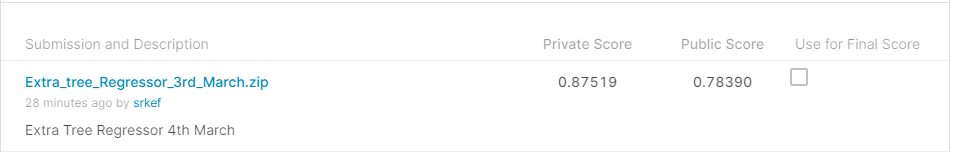

### B. Random Forest Regressor

In [ ]:
%%time

wrmsse=[]
number_of_trees = []
depth_of_trees=[]


for kk in tqdm(range(10)):
    df_sales1 = df_sales.copy()

    number_of_tree = random.randint(20, 50)
    depth_of_tree = random.randint(10, 30)

    print("number_of_tree ",number_of_tree)
    print("depth_of_tree ",depth_of_tree)
   
    
    model = RandomForestRegressor(n_estimators=number_of_tree, max_depth=depth_of_tree,n_jobs=-1)

    model.fit(X, Y)

    pred_test = model.predict(cross_X)
    pred_df = pd.DataFrame(pred_test)
    pred_df.columns = ['F_' + str(c) for c in np.arange(1,29,1)]

    WRMSSE = hyperparameter_tuning(pred_df,df_sales1)

    model_name = 'RandomForestRegressor'+'_Model_' +str(kk) +'.pkl'
    # save model
    joblib.dump(model, model_name)

    wrmsse.append(WRMSSE)
    number_of_trees.append(number_of_tree)
    depth_of_trees.append(depth_of_tree) 


  0%|          | 0/10 [00:00<?, ?it/s]

number_of_tree  29
depth_of_tree  11


 10%|█         | 1/10 [03:32<31:53, 212.56s/it]

0.931682964936932
number_of_tree  49
depth_of_tree  14


 20%|██        | 2/10 [10:07<35:38, 267.32s/it]

0.894218464420305
number_of_tree  39
depth_of_tree  10


 30%|███       | 3/10 [14:24<30:48, 264.04s/it]

0.930260404543155
number_of_tree  40
depth_of_tree  21


 40%|████      | 4/10 [22:02<32:14, 322.35s/it]

0.8606956341637753
number_of_tree  23
depth_of_tree  23


 50%|█████     | 5/10 [27:17<26:40, 320.12s/it]

0.8565719226279195
number_of_tree  27
depth_of_tree  11


 60%|██████    | 6/10 [30:17<18:32, 278.23s/it]

0.920932252675005
number_of_tree  38
depth_of_tree  11


 70%|███████   | 7/10 [34:50<13:49, 276.50s/it]

0.9237107637472086
number_of_tree  45
depth_of_tree  30
0.8443204321604256


 80%|████████  | 8/10 [46:03<13:11, 395.56s/it]

number_of_tree  31
depth_of_tree  12


 90%|█████████ | 9/10 [50:01<05:48, 348.22s/it]

0.9033751231909181
number_of_tree  20
depth_of_tree  12


100%|██████████| 10/10 [52:27<00:00, 314.75s/it]

0.9109834015182187
CPU times: user 1h 38min 21s, sys: 14.6 s, total: 1h 38min 35s
Wall time: 52min 27s


In [ ]:
wrmsse

[0.931682964936932,
 0.894218464420305,
 0.930260404543155,
 0.8606956341637753,
 0.8565719226279195,
 0.920932252675005,
 0.9237107637472086,
 0.8443204321604256,
 0.9033751231909181,
 0.9109834015182187]

In [ ]:
# load model 7
best_Model  =  joblib.load('RandomForestRegressor_Model_7.pkl')

In [ ]:
xx  = best_Model.predict(test_X)

In [ ]:
pred_df = pd.DataFrame(xx)
pred_df.columns = ['F' + str(c) for c in np.arange(1,29,1)]

sub3 = pd.concat([sales['id'], pred_df], axis=1, sort=False)

sub4 = sub3.copy()
sub4["id"] = sub4["id"].apply(lambda x: x.replace('evaluation', 'validation'))  


final =   pd.concat([sub3, sub4], axis=0, sort=False)

final.to_csv("Final_Data12.csv",index= False)

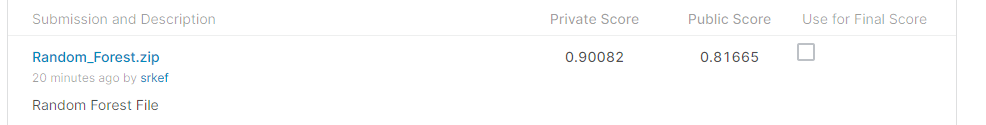